# 47.10 asyncio 사용하기
- asyncio(Asynchronous I/O): 비동기 프로그래밍을 위한 모듈
- CPU작업과 I/O를 병렬로 처리하게 해줌 
- 동기(synchronous)와 비동기(asynchronous)
    - 동기처리(synchronous) : 특정 작업이 끝나면 다음 작업을 처리하는 순차처리 방식
    - 비동기처리(asynchronous) : 여러 작업을 처리하도록 예약한 뒤 작업이 끝나면 결과를 받는 방식  
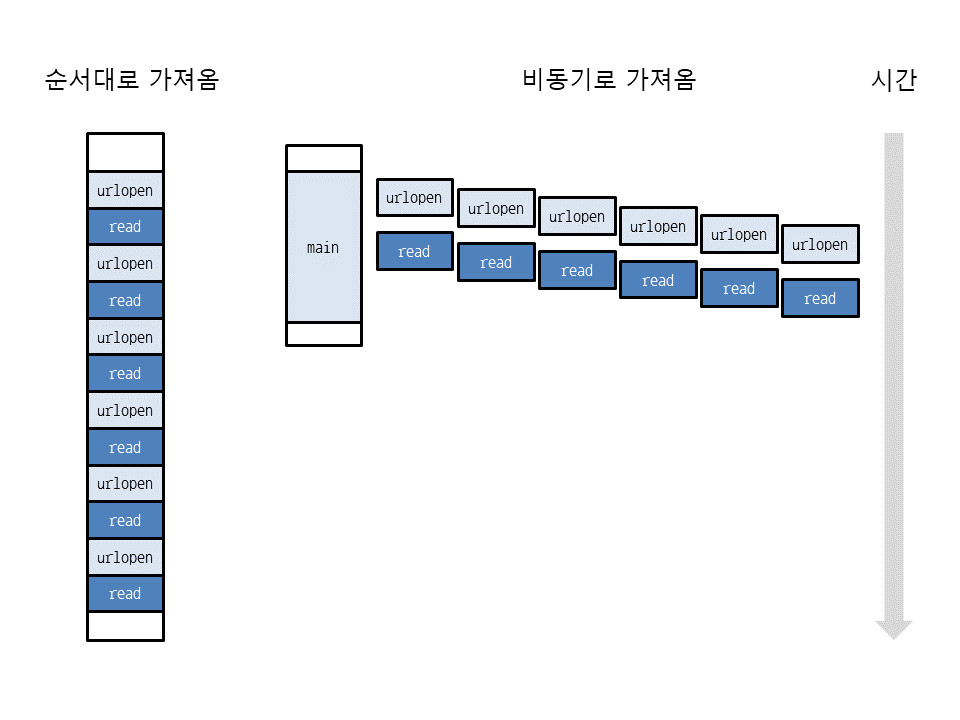
    
**네이티브 코루틴 만들기**

In [6]:
import asyncio
import nest_asyncio

nest_asyncio.apply()

async def hello():
    print('Hello World')
    
loop = asyncio.get_event_loop()
loop.run_until_complete(hello())
loop.close()

Hello World


RuntimeError: Cannot close a running event loop

**RuntimeError 수정**

In [8]:
import asyncio
import nest_asyncio

nest_asyncio.apply()

async def hello():
    print('Hello World')
    
loop = asyncio.get_event_loop()

try:
    loop.run_until_complete(hello())
except Exception as e:
    hello().cancel()
    loop.check_in_records()
    loop.reconnect()
    loop.start_job()
    hello().exception()

Hello World


## await로 네이티브 코루틴 실행하기 
- 다음과 같이 await뒤에 코루틴 객체, 퓨처객체, 태스크 객체를 지정하면 해당 객체가 끝날 때까지 기다린 뒤 결과를 반환함
- await : 특정 객체가 끝날 때 까지 기다림
- Python 3.5이상부터 사용 가능, 3.4에서는 yield from 사용 
- await는 네이티브 코루틴 안에서만 사용할 수 있다. 

In [9]:
async def add(a, b):
    print('add: {0} + {1}'.format(a, b))
    await asyncio.sleep(1.0)  # 1초 대기 (네이티브 코루틴)
    return a+b

async def print_add(a, b):
    result = await add(a, b)
    print('print_add: {0}+{1}={2}'.format(a, b, result))

loop = asyncio.get_event_loop()
loop.run_until_complete(print_add(1, 2))
loop.close()

add: 1 + 2
print_add: 1+2=3


RuntimeError: Cannot close a running event loop

In [10]:
async def add(a, b):
    print('add: {0} + {1}'.format(a, b))
    await asyncio.sleep(1.0)  # 1초 대기 (네이티브 코루틴) : 코루틴 안에서 코루틴을 사용할 때 await를 쓴다.
    return a+b

async def print_add(a, b):
    result = await add(a, b)
    print('print_add: {0}+{1}={2}'.format(a, b, result))

loop = asyncio.get_event_loop()


try:
    loop.run_until_complete(print_add(1, 2))
except Exception as e:
    print_add(1, 2).cancel()
    loop.check_in_records()
    loop.reconnect()
    loop.start_job()
    print_add(1, 2).exception()

add: 1 + 2
print_add: 1+2=3


- 비동기로 웹 페이지 가져오기  
: 비효율적

In [12]:
from time import time
from urllib.request import Request, urlopen

urls = ['https://www.google.co.kr/search?q=' + i for i in ['apple', 'pear', 'grape', 'pineapple', 'orange', 'strawberry']]

begin = time()
result = []
for url in urls:
    request = Request(url, headers={'User-Agent':'Mozilla/5.0'})
    response = urlopen(request)
    page = response.read()
    result.append(len(page))
    
print(result)
end = time()
print('실행 시간: {0:.3f}초'.format(end-begin))

[211655, 145104, 92153, 73754, 137008, 94175]
실행 시간: 6.275초


In [15]:
urls = ['https://www.google.co.kr/search?q=' + i for i in ['apple', 'pear', 'grape', 'pineapple', 'orange', 'strawberry']]

async def fetchc(url):
    request = Request(url, headers={'User-Agent':'Mozilla/5.0'})
    response = await loop.run_in_executor(None, urlopen, request)  # run_in_executor 
    page = await loop.run_in_executor(None, response.read)         # run_in_executor 
    return len(page)


async def main():
    futures = [asyncio.ensure_future(fetch(url)) for url in urls]
    
    result = await asyncio.gather(*futures)
    print(result)
    
begin = time()
loop = asyncio.get_event_loop()


try:
    loop.run_until_complete(main())
except Exception as e:
    main().cancel()
    loop.check_in_records()
    loop.reconnect()
    loop.start_job()
    main().exception()
end = time()
print('실행 시간: {0:.3f}초'.format(end-begin))

[211598, 145106, 92178, 73754, 137008, 94212]
실행 시간: 6.687초


- urlopen, response.read 등의 함수(메서드)는 결과가 나올 때까지 코드 실행이 중단(block)되는데 이런 함수들을 블로킹 I/O (blocking I/O) 함수라고 부름 
- 네이티브 코루틴 안에서 블로킹 I/O 함수를 실행하려면 이벤트 루프의 run_in_executor 함수를 사용하여 다른 스레드에서 병렬로 실행시켜야함 
- run_in_executor의 첫 번째 인수는 executor인데 함수를 실행시켜줄 스레드 풀 또는 프로세스 풀임 
- run_in_executor도 네이티브 코루틴이므로 await로 실행한 뒤 결과를 가져옴  

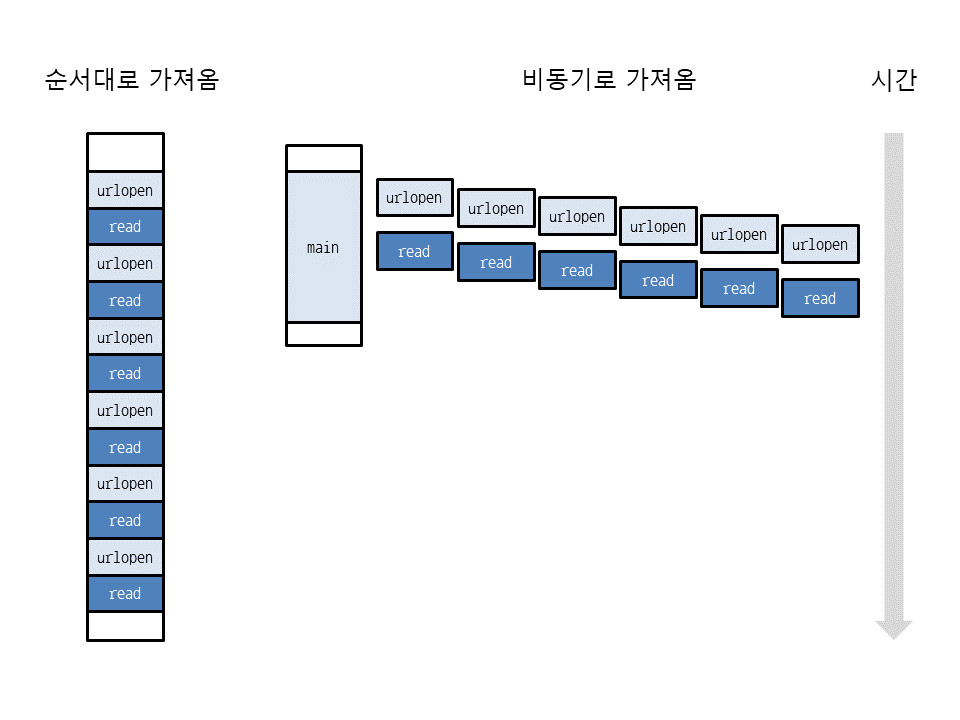

## async wih
- with 다음에 클래스의 인스턴스 지정, as 뒤에 결과를 저장할 변수를 지정 
- Python 3.5이상부터 사용 가능 
- \__aenter__와 \__aexit\___ 메서드를 구현해야함 

In [17]:
class AsyncAdd:
    def __init__(self, a, b):
        self.a = a
        self.b = b
        
    async def __aenter__(self):
        await asyncio.sleep(1.0)
        return self.a + self.b
    
    async def __aexit__(self, exc_type, exc_value, traceback):
        pass       # 메소드 자체가 없으면 오류 발생

async def main():
    async with AsyncAdd(1, 2) as result:
        print(result)
    
loop = asyncio.get_event_loop()
try:
    loop.run_until_complete(main())
except Exception as e:
    main().cancel()
    loop.check_in_records()
    loop.reconnect()
    loop.start_job()
    main().exception()

3


## async for 
- \__aiter__ 와 \__anext__ 메소드를 구현해야함 
- Python 3.5 이상부터 사용 가능 

In [22]:
class AsyncCounter:
    def __init__(self, stop):
        self.current = 0
        self.stop = stop
        
    def __aiter__(self):
        return self
    
    async def __anext__(self):
        if self.current < self.stop:
            await asyncio.sleep(1.0)
            r = self.current
            self.current += 1
            return r
        else:
            raise StopAsyncIteration
            
async def main():
    async for i in AsyncCounter(3):
        print(i, end=' ')
    
loop = asyncio.get_event_loop()
try:
    loop.run_until_complete(main())
except Exception as e:
    main().cancel()
    loop.check_in_records()
    loop.reconnect()
    loop.start_job()
    main().exception()

0 1 2 